## Trabalho 1 - Avaliação e Desempenho

---

**Alunos**:

Claudio Netto - 113166858

Gabriel Christo - 117217732

Yago Alves - 115212477

Yuri Medeiros - 117061898

---

In [ ]:
import random
import math
from pprint import pprint
from math import isclose
from collections import deque
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt
import heapq
import scipy

import numpy as np
from scipy.stats import expon

In [ ]:
# Constantes
discipline = "FCFS"
ARRIVAL = 0
END_OF_SERVICE = 1
MU = 1.0
IDLE = 0
BUSY = 1
FIFO = 0
LIFO = 1

N_RODADAS = 3200
MIN_CLIENTES = 100

T_PERCENTILE = 1.960 # alpha = 0.05

In [ ]:
def generate_exp(lambda_param):
  u0 = random.random() # Gera a variavel aleatoria uniforme no intervalo [0.0, 1.0)
  x0 = - math.log(u0) / lambda_param # Pega amostra da exponencial
  return x0

In [ ]:
import queue

class Event:
    def __init__(self, event_type, ocurrence_time, client_id):
        self.event_type = event_type # Chegada ou fim de serviço
        self.t = ocurrence_time # Instante que o evento ocorre
        self.client_id = client_id # ID do cliente ao qual o evento esta relacionado


    def __lt__(self, other):
        return self.t < other.t


  # Define como a classe vai ser impressa
    def __repr__(self) -> str:
        if self.event_type == ARRIVAL:
            type_str = "ARRIVAL"
        else:
            type_str = "END_OF_SERVICE"
        return f"event_type: {type_str}\nt: {self.t}\nclient_id: {self.client_id}"

class EventsList:
  def __init__(self):
    self.events = queue.PriorityQueue()
  def add(self, event):
    self.events.put(event)
  def pop(self):
    # Pega o evento que ocorre mais cedo, já que a lista esta ordenada pelos tempos
    return self.events.get()

  def clear(self):
    self.events.queue.clear()

def get_event_time(event):
  return event.t

In [ ]:
class Client:
    def __init__(self, arrival_event):
        self.id = arrival_event.client_id
        self.arrival_time = arrival_event.t
        self.waiting_time = 0.0
        self.service_time = 0.0

    def __repr__(self) -> str:
        return f"Client ID: {self.id}\nArrival Time: {self.arrival_time}\nWaiting Time: {self.waiting_time}"


def create_client(event):
  new_client = Client(event)
  return new_client

class ClientsQueue:
  def __init__(self):
    self.clients = deque([])
  def add(self, client):
    self.clients.append(client)
  def pop(self):
      return self.clients.popleft()
  def clear(self):
    self.clients.clear()


def serve_client(client, t, service_dist, events_list):
  # Registra o tempo de espera do serviço
  client.waiting_time = t - client.arrival_time
  # Cria evento do fim do serviço
  end_of_service_event = generate_end_of_service(t, service_dist, client.id)
  client.service_time = end_of_service_event.t - (client.arrival_time + client.waiting_time)
  # Adiciona evento do fim do servico a lista de eventos
  events_list.add(end_of_service_event)

In [ ]:
def generate_arrival(start_time, arrival_dist, client_id):
  arrival = Event(ARRIVAL, start_time + arrival_dist(), client_id)
  return arrival

def generate_end_of_service(t, service_dist, client_id):
  end_of_service = Event(END_OF_SERVICE, t + service_dist(), client_id)
  return end_of_service

In [ ]:
class Estimator:
  def __init__(self):
    self.samples_list = [] # amostras
    self.samples_sum = 0.0 # Soma das amostras
    self.squares_sum = 0.0 # Soma dos quadrados das amostras
    self.n = 0 # Numero de amostras
  def add_sample(self, sample):
    self.samples_list.append(sample)
    self.samples_sum += sample
    self.squares_sum += (sample**2)
    self.n += 1
  def get_samples_list(self):
    return self.samples_list
  def mean(self):
    return self.samples_sum / self.n
  def variance(self):
    term1 = self.squares_sum / (self.n - 1)
    term2 = (self.samples_sum**2) / (self.n * (self.n - 1))
    return term1 - term2
  def tstudent_ci(self):
    term = T_PERCENTILE * (math.sqrt(self.variance())/math.sqrt(N_RODADAS))
    return self.mean() - term, self.mean() + term
  def clear(self):
    self.samples_sum = 0.0
    self.samples_list = []
    self.squares_sum = 0.0
    self.n = 0

class NqueueAreaEstimator:
  def __init__(self):
    # Soma das areas
    self.nqueue_area_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_area_sum += nqueue * dt
    self.dt_sum += dt
  def mean(self):
    return self.nqueue_area_sum / self.dt_sum
  def clear(self):
    self.nqueue_area_sum = 0.0
    self.dt_sum = 0.0

class NqueuePmfEstimator:
  def __init__(self):
    # Soma dos quadrados dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_squares_sum = 0.0
    # Soma dos Nqis coletados vezes o intervalo de tempo
    self.nqueue_sum = 0.0
    # Soma dos intervalos de tempo
    self.dt_sum = 0.0
  def add_sample(self, nqueue, dt):
    self.nqueue_squares_sum += (nqueue**2) * dt
    self.nqueue_sum += nqueue * dt
    self.dt_sum += dt
  def variance(self):
    second_moment = self.nqueue_squares_sum / self.dt_sum
    first_moment = self.nqueue_sum / self.dt_sum
    return second_moment - (first_moment**2)
  def clear(self):
    self.nqueue_squares_sum = 0.0
    self.nqueue_sum = 0.0
    self.dt_sum = 0.0

In [ ]:
tempos_espera = 0

def print_CDF(num_clientes,tempos_espera):

  tempos_espera = np.sort(tempos_espera)
  cdf = np.arange(1, len(tempos_espera) + 1) / len(tempos_espera)

  # plotando cdfs
  fig, axes = plt.subplots(1, 2, figsize=(14, 6))
  axes[0].plot(tempos_espera, cdf, marker='o')
  axes[0].set_xlabel('Tempo Médio de Espera')
  axes[0].set_ylabel('CDF')
  axes[0].set_title('CDF a partir dos Tempos Médios de Espera')
  axes[0].grid(True)

  num_clientes = np.sort(num_clientes)
  cdf_2 = np.arange(1, len(num_clientes) + 1) / len(num_clientes)

  axes[1].plot(num_clientes, cdf_2, marker='o')
  axes[1].set_xlabel('Quantidade média de clientes ao longo das rodadas')
  axes[1].set_ylabel('CDF')
  axes[1].set_title('CDF a partir da quantidade média de clientes')
  axes[1].grid(True)

  plt.show()


In [ ]:
def plotAll(
    time_est,
    time_var_est,
    nqueue_est,
    nqueue_var_est,
    empty_queue_estimator,
    discipline,
    W,
    Nq,
    W2, # redundante
    busy_time,
    estimador_cliente_tempo_total,
    estimador_cliente_tempo_servico
):


    # Obtem os intervalos de confiança e seus centros
    # utilizamos a t-student para calcular a
    # o ic da media de tempo, variancia do tempo, media de clientes na fila (Nq)
    # variancia de clientes na fila (Nq)
    w_mean_lower, w_mean_upper = time_est.tstudent_ci()
    w_mean_center = time_est.mean()

    w_var_lower2, w_var_upper2 = time_var_est.tstudent_ci()
    w_var_center2 = time_var_est.mean()

    nq_mean_lower, nq_mean_upper = nqueue_est.tstudent_ci()
    nq_mean_center = nqueue_est.mean()

    nq_var_lower2, nq_var_upper2 = nqueue_var_est.tstudent_ci()
    nq_var_center2 = nqueue_var_est.mean()

    # sistema atingindo estado zero
    low, up = empty_queue_estimator.tstudent_ci()
    mean = empty_queue_estimator.mean()

    # tempo clientes no sistema
    low_cl, up_cl = estimador_cliente_tempo_total.tstudent_ci()

    # tempo servico clientes
    low_cl_service, up_cl_service = estimador_cliente_tempo_servico.tstudent_ci()

    # grafico das amostras de Wplt.subplots(3, 2, figsize=(10, 12))
    # grafico das amostras de W
    fig, axes = plt.subplots(4, 2, figsize=(12, 14), dpi=100)

    axes[0][0].hist(
        time_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    axes[0][0].set_xlabel("Amostras E(W)")
    axes[0][0].set_ylabel("Densidade")
    axes[0][0].set_title("Média da média de W por rodadas/ Densidade Amostral")
    axes[0][0].grid(True)

    axes[0][1].hist(
        nqueue_est.get_samples_list(),
        density=True,
        color="lightgrey",
        edgecolor="darkgrey",
        bins="scott",
    )
    axes[0][1].set_xlabel("Amostras E(Nq)")
    axes[0][1].set_ylabel("Densidade")
    axes[0][0].set_title("Média da média de Nq por rodadas/ Densidade Amostral")
    axes[0][1].grid(True)

    tempo_servindo_values = [item["tempo_servindo"] for item in busy_time]
    axes[1][0].hist(
        tempo_servindo_values,
        bins=30,
        edgecolor="darkgrey",
    )
    axes[1][0].set_xlabel("TEMPO DE SERVICO")
    axes[1][0].set_ylabel("densidade")
    axes[1][0].grid(True)

    # densidade x clientes
    axes[1][1].hist(
        np.sort(W),
        bins=30,
        edgecolor="darkgrey",
    )
    axes[1][1].set_xlabel("E(W)")
    axes[1][1].set_ylabel("densidade")
    axes[1][1].grid(True)

    # tempo total dos clientes no sistema (fila + serviço)
    axes[2][0].hist(
        estimador_cliente_tempo_total.get_samples_list(),
        bins="scott",
        edgecolor="darkgrey",
    )
    axes[2][0].set_xlabel("tempo total clientes no sistema")
    axes[2][0].set_ylabel("densidade")
    axes[2][0].grid(True)

    # tempo de serviço dos clientes no sistema
    axes[2][1].hist(
        estimador_cliente_tempo_servico.get_samples_list(),
        bins="scott",
        edgecolor="darkgrey",
    )
    axes[2][1].set_xlabel("tempo de serviço clientes no sistema")
    axes[2][1].set_ylabel("densidade")
    axes[2][1].grid(True)


    axes[3][1].plot(W, label=f"'FIFO' - ρ = colocar o rô aqui")
    axes[3][1].set_title("Gráfico da transiente - E[W]")
    axes[3][1].set_xlabel("Rodadas")
    axes[3][1].set_ylabel("E[W]")
    axes[3][1].grid(True)


    axes[3][0].plot(Nq, label=f"'FIFO' - ρ = colocar o rô aqui")
    axes[3][0].set_title("Gráfico da transiente - E[Nq]")
    axes[3][0].set_xlabel("Rodadas")
    axes[3][0].set_ylabel("E[Nq]")
    axes[3][0].grid(True)

    # numero de clientes na fila
    plt.figure(num=3, figsize=(8, 5), dpi=100)
    tmp = []
    for i in range(MIN_CLIENTES):
        for item in n_clients_list[i]:
            tmp.append(item)
    plt.plot(tmp, label=f"Numero de clientes de fila")
    plt.title("Numero de clientes de fila")
    plt.xlabel("ciclos")
    plt.ylabel("#Clientes")
    plt.grid(True)
    fig.tight_layout(pad=5.0)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(
        range(0, len(empty_queue_estimator.get_samples_list())),
        empty_queue_estimator.get_samples_list(),
    )
    plt.xlabel("RodadaS")
    plt.ylabel("# de vezes que sistema atinge estado zero")
    plt.show()

    print_CDF(Nq, W)

    print("Média de W")  # W :  Tempo de espera na fila
    print(f"IC: {w_mean_lower:.3f} a {w_mean_upper:.3f}")
    print("Variância de W")
    print(f"IC: {w_var_lower2:.3f} a {w_var_upper2:.3f}\n")
    print("Média de Nq")  # Nq : numero clientes na fila
    print(f"IC: {nq_mean_lower:.3f} a {nq_mean_upper:.3f}")
    print("Variância de Nq")
    print(f"IC: {nq_var_lower2:.3f} a {nq_var_upper2:.3f}\n")
    print("Média de vezes que sistema atinge estado zero por rodada")
    print(f"IC: {low:.3f} a {up:.3f}\n")
    print("Média de tempo total dos clientes no sistema")
    print(f"IC: {low_cl:.3f} a {up_cl:.3f}\n")
    print("Média de tempo de serviço dos clientes no sistema")
    print(f"IC: {low_cl_service:.3f} a {up_cl_service:.3f}\n")


    print(f"\n[CORRETUDE] Calculando a Lei de little com base nos estimadores de")
    print("[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda")
    print(
        f"[CORRETUDE] Littles Law: {nqueue_est.mean()/estimador_cliente_tempo_total.mean()}\n"
    )  # tem que dar igual o lambda
#
#     return {
#         "time_mean": [discipline, w_mean_lower, w_mean_upper, w_mean_center],
#         "time_var_t": [discipline, w_var_lower2, w_var_upper2, w_var_center2],
#         "nqueue_mean": [discipline, nq_mean_lower, nq_mean_upper, nq_mean_center],
#         "nqueue_var_t": [discipline, nq_var_lower2, nq_var_upper2, nq_var_center2],
#         "time_graph_values": W,
#         "nqueue_graph_values": Nq,
#     }


In [ ]:
n_clients_list = []
estimador_tempo_total = Estimator()
estimador_tempo_ocioso = Estimator()
estimador_tempo_servindo = Estimator()
estimador_cliente_tempo_total = Estimator()
estimador_cliente_tempo_servico = Estimator()

def simulate(rounds, round_size, arrival_dist, service_dist):
    # estimadores
    media_tempo_por_rodada = []

    # Estimadores de tempo de espera e tamanho da fila
    time_est = Estimator()
    nqueue_est = Estimator()

    # Estimadores da variancia pela t-student
    time_var_est = Estimator()
    nqueue_var_est = Estimator()

    empty_queue_estimator = Estimator()

    W = []  # lista com os valores do estimador de E[W] ao longo do tempo
    Nq = []  # lista com numeros de individuos na fila em cada rodada

    empty_queue_ocurrences = 0
    busy_time = []

    # start up sistema
    t = 0.0
    nqueue = 0
    cliente_sendo_servido = None

    ## sistema começa com 1 chegada
    client_id = 0
    first_arrival = generate_arrival(
        start_time=t, arrival_dist=arrival_dist, client_id=client_id
    )
    events_list = EventsList()
    events_list.add(first_arrival)
    clients_queue = ClientsQueue()  # fila de espera
    client_id += 1

    for i in range(rounds):
        #print(f'\nCOMEÇANDO RODADA {i} da simulação')

        served_clients = 0
        # Inicia os estimadores de tempo de espera e tamanho da fila da rodada
        round_time_est = Estimator()
        round_nqueue_est = NqueueAreaEstimator()
        round_nqueue_pmf_est = NqueuePmfEstimator()

        nqueue = 0  # zerando tamanho da fila

        n_clientes_por_rodada = []

        # metricas de nascimento e morte
        servidor_ocioso = False
        ciclos_ociosos = 0
        tempo_periodo_ocioso = 0
        inicio_periodo_ocioso = 0  # tempo da ultima morte
        busy_time_counter = 0

        while (
            served_clients < round_size
        ):  # round size é o minimo de clientes atendidos
            #print(
            #    f"\nNew Round\n{served_clients} de  {round_size}\nEventos na fila de espera: {nqueue}"
            #)

            event = events_list.pop()
            round_nqueue_est.add_sample(
                # se tivermos um cliente sendo atendido somamos mais um no numero de clientes no sistema
                nqueue if cliente_sendo_servido == None else nqueue + 1,
                event.t - t,
            )
            round_nqueue_pmf_est.add_sample(nqueue, event.t - t)

            # Avança o tempo para o instante do evento
            t = event.t

            #print(f"tempo de simulação {t}\nEvento atual: \n{event}\n")
            if event.event_type == ARRIVAL:
                novo_cliente = create_client(event)

                if servidor_ocioso:
                    ciclos_ociosos += 1
                    tempo_periodo_ocioso += t - inicio_periodo_ocioso
                    servidor_ocioso = False

                if not cliente_sendo_servido:
                    cliente_sendo_servido = novo_cliente
                    serve_client(
                        novo_cliente, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista TODO: EXPLICAR MELHOR
                else:
                    clients_queue.add(novo_cliente)
                    nqueue += 1  # Incrementa numero de clientes na fila de espera

                nova_chegada = generate_arrival(
                    start_time=t, arrival_dist=arrival_dist, client_id=client_id
                )
                client_id += 1
                events_list.add(nova_chegada)
            else:
                served_clients += 1
                #print(f"service time do {cliente_sendo_servido.id} : {cliente_sendo_servido.service_time}")
                #print(f"waiting time do {cliente_sendo_servido.id} : {cliente_sendo_servido.waiting_time}")

                round_time_est.add_sample(
                    cliente_sendo_servido.waiting_time
                )  # Salva o tempo de espera do cliente que acabou o serviço
                busy_time_counter += cliente_sendo_servido.service_time

                estimador_cliente_tempo_total.add_sample(
                    cliente_sendo_servido.waiting_time
                    + cliente_sendo_servido.service_time
                )

                estimador_cliente_tempo_servico.add_sample(
                    cliente_sendo_servido.service_time
                )

                if nqueue == 0:
                    #print("[*****] Fila de espera vazia")
                    cliente_sendo_servido = None

                    empty_queue_ocurrences += 1
                    inicio_periodo_ocioso = t
                    servidor_ocioso = True
                else:
                    # caso a fila de espera nao esteja vazia, pegamos o proximo
                    client = clients_queue.pop()
                    cliente_sendo_servido = client
                    serve_client(
                        client, t, service_dist, events_list
                    )  # Registra tempo de espera e adiciona evento do fim do serviço na lista

                    nqueue -= 1  # Decrementa numero de clientes na fila de espera

            n_clientes_por_rodada.append(nqueue)

        # estimadores por rodada
        estimador_tempo_total.add_sample(t)
        estimador_tempo_ocioso.add_sample(tempo_periodo_ocioso)
        estimador_tempo_servindo.add_sample(busy_time_counter)
        busy_time.append(
            {
                "tempo_sistema": t,
                "tempo_ocioso": tempo_periodo_ocioso,
                "qtd_ciclos_ociosos": ciclos_ociosos,
                "tempo_servindo": busy_time_counter,
            }
        )

        n_clients_list.append(n_clientes_por_rodada)

        # print(f'Fracao periodo ocupado: {ciclos_ociosos}')
        # print(f'Tempo Ocioso do sistema: {tempo_periodo_ocioso}')
        inicio_periodo_ocioso = 0  # death_time
        # checa se o sistema ocupado
        # print(f'empty_queue_ocurrences:: {empty_queue_ocurrences}')
        ###

        # salvando numero de vezes que sistema atingiu estado zero na rodada atual
        empty_queue_estimator.add_sample(empty_queue_ocurrences)
        empty_queue_ocurrences = 0

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        cliente_sendo_servido = None
        client_id = 0
        t = 0
        clients_queue.clear()
        events_list.clear()
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

        # Calcula a estatisticas de W e Nq da rodada (amostras da rodada)
        round_time_mean = round_time_est.mean()
        round_time_var = round_time_est.variance()
        round_nqueue_mean = round_nqueue_est.mean()
        round_nqueue_var = round_nqueue_pmf_est.variance()

        # Salva as amostras da rodada nos estimadores gerais
        time_est.add_sample(round_time_mean)
        time_var_est.add_sample(round_time_var)
        nqueue_est.add_sample(round_nqueue_mean)
        nqueue_var_est.add_sample(round_nqueue_var)

        # zerando estimadores
        round_time_est.clear()
        round_nqueue_est.clear()
        round_nqueue_pmf_est.clear()

        # Salva amostras para o grafico, se desejado
        media_tempo_por_rodada.append(round_time_mean)
        W.append(time_est.mean())
        Nq.append(nqueue_est.mean())

    plotAll(
        time_est,
        time_var_est,
        nqueue_est,
        nqueue_var_est,
        empty_queue_estimator,
        discipline,
        W,
        Nq,
        media_tempo_por_rodada,
        busy_time,
        estimador_cliente_tempo_total,
        estimador_cliente_tempo_servico
    )

    total_qtd_ciclos_ociosos = sum(item["qtd_ciclos_ociosos"] for item in busy_time)
    print(f'Total de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)}')
    print(f'Fração de ciclos ocupados {(N_RODADAS * MIN_CLIENTES - total_qtd_ciclos_ociosos)/N_RODADAS* MIN_CLIENTES}')

    print(f'Total de periodos ociosos: {(total_qtd_ciclos_ociosos)}')

    print(f'Fração de periodos ociosos: {(total_qtd_ciclos_ociosos)/N_RODADAS*MIN_CLIENTES}')

   #pprint(busy_time)


## Caso 1 - Fila MM1

p = 0.5

lambda = 1

mi = 2

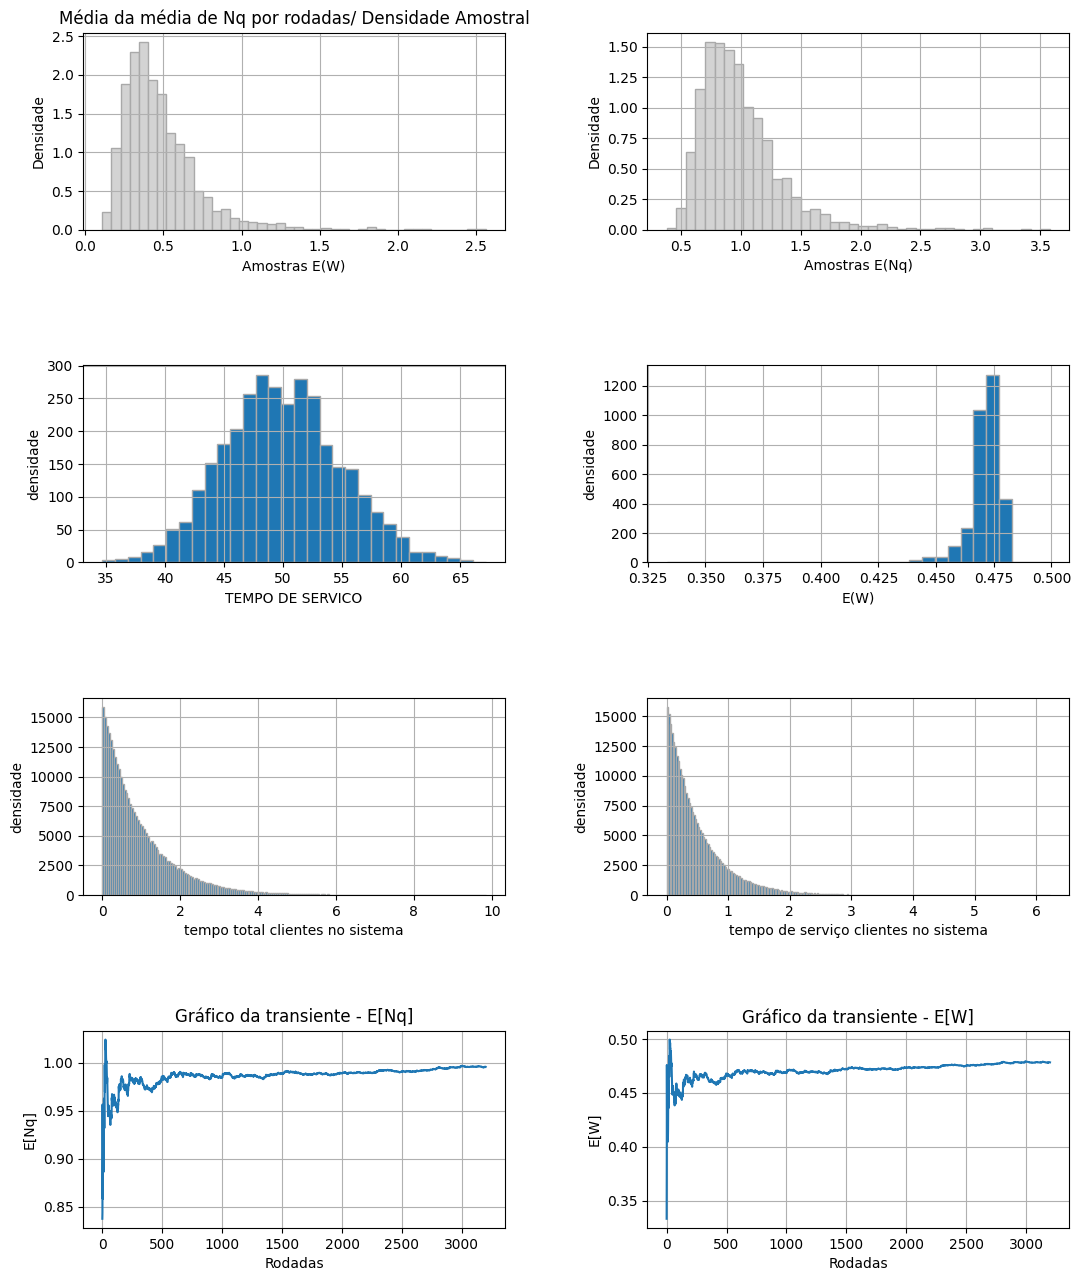

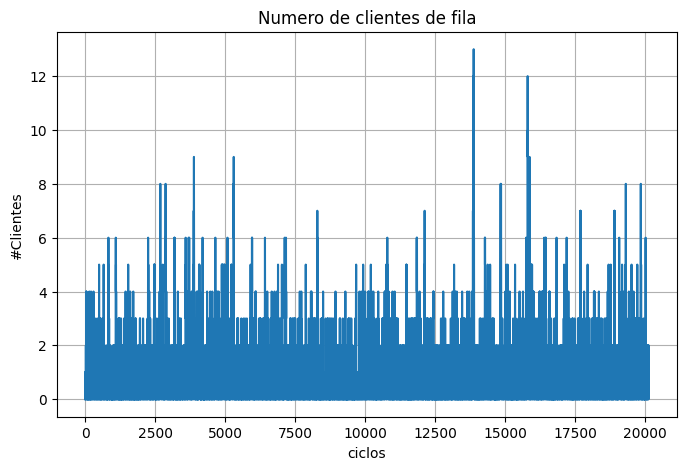

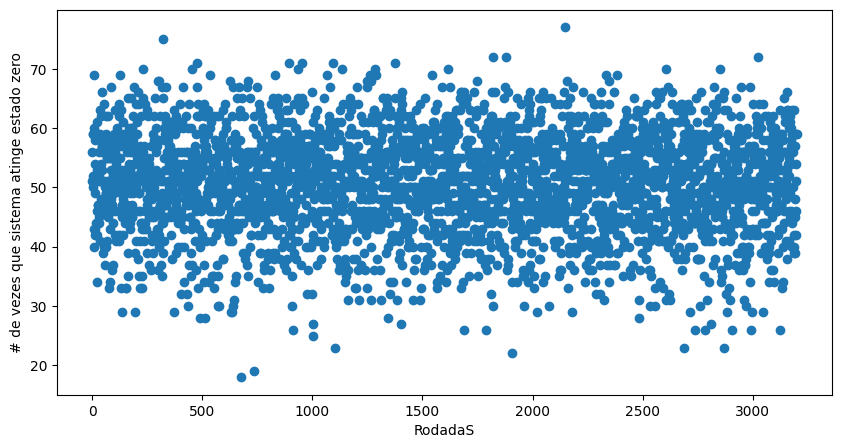

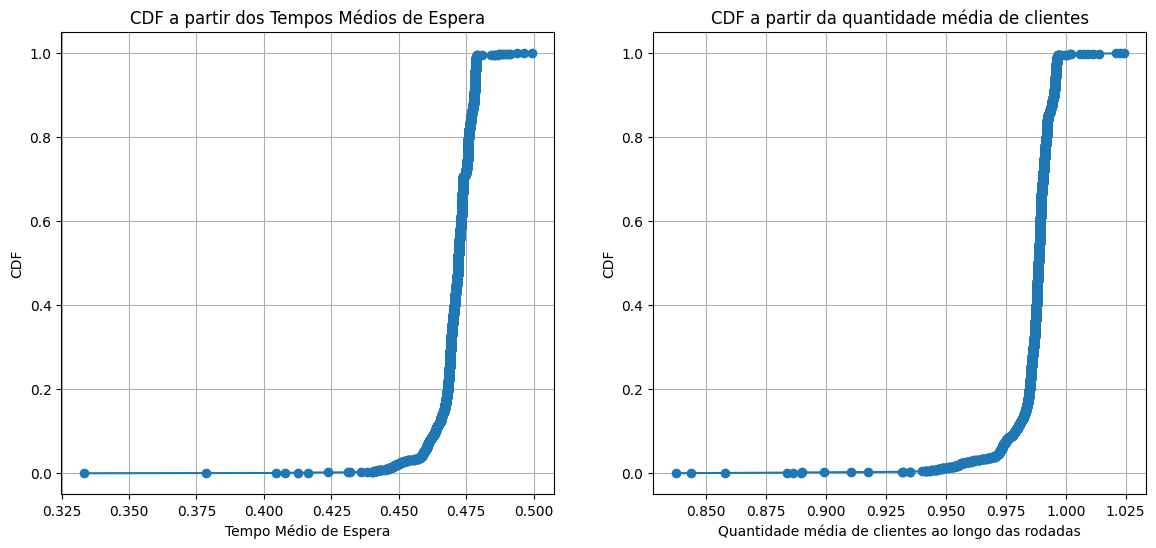

Média de W
IC: 0.470 a 0.487
Variância de W
IC: 0.624 a 0.669

Média de Nq
IC: 0.984 a 1.008
Variância de Nq
IC: 1.108 a 1.191

Média de vezes que sistema atinge estado zero por rodada
IC: 50.201 a 50.780

Média de tempo total dos clientes no sistema
IC: 0.943 a 1.011

Média de tempo de serviço dos clientes no sistema
IC: 0.482 a 0.516


[CORRETUDE] Calculando a Lei de little com base nos estimadores de
[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda
[CORRETUDE] Littles Law: 1.0190316643963804

Total de ciclos ocupados 160022
Fração de ciclos ocupados 5000.6875
Total de periodos ociosos: 159978
Fração de periodos ociosos: 4999.3125
[CORRETUDE] media do tempo de servico: 49.71868776216045 - 50.061902341576165
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 100.7530834619649 - 101.45329794334808
[CORRETUDE] Rho: 0.49345915499932325



In [ ]:
random.seed(0 )
def exp10():
  return generate_exp(1.0)

def exp20():
  return generate_exp(2.0)

estimador_tempo_total.clear()
estimador_tempo_ocioso.clear()
estimador_tempo_servindo.clear()
estimador_cliente_tempo_total.clear()
estimador_cliente_tempo_servico.clear()

simulate(N_RODADAS, MIN_CLIENTES, exp10, exp20)

# Tempo total é o tempo do sistema(ocioso+ ocupado)
low_rho, up_rho = estimador_tempo_servindo.tstudent_ci()
print(f"[CORRETUDE] media do tempo de servico: {low_rho} - {up_rho}")

low_total, up_total = estimador_tempo_total.tstudent_ci()
print(f"[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): {low_total} - {up_total}")

print(f"[CORRETUDE] Rho: {estimador_tempo_servindo.mean()/estimador_tempo_total.mean()}\n")
#lambda = 1



## Caso 2 - Fila MM1

p = 0.5

lambda = 2

mi = 4

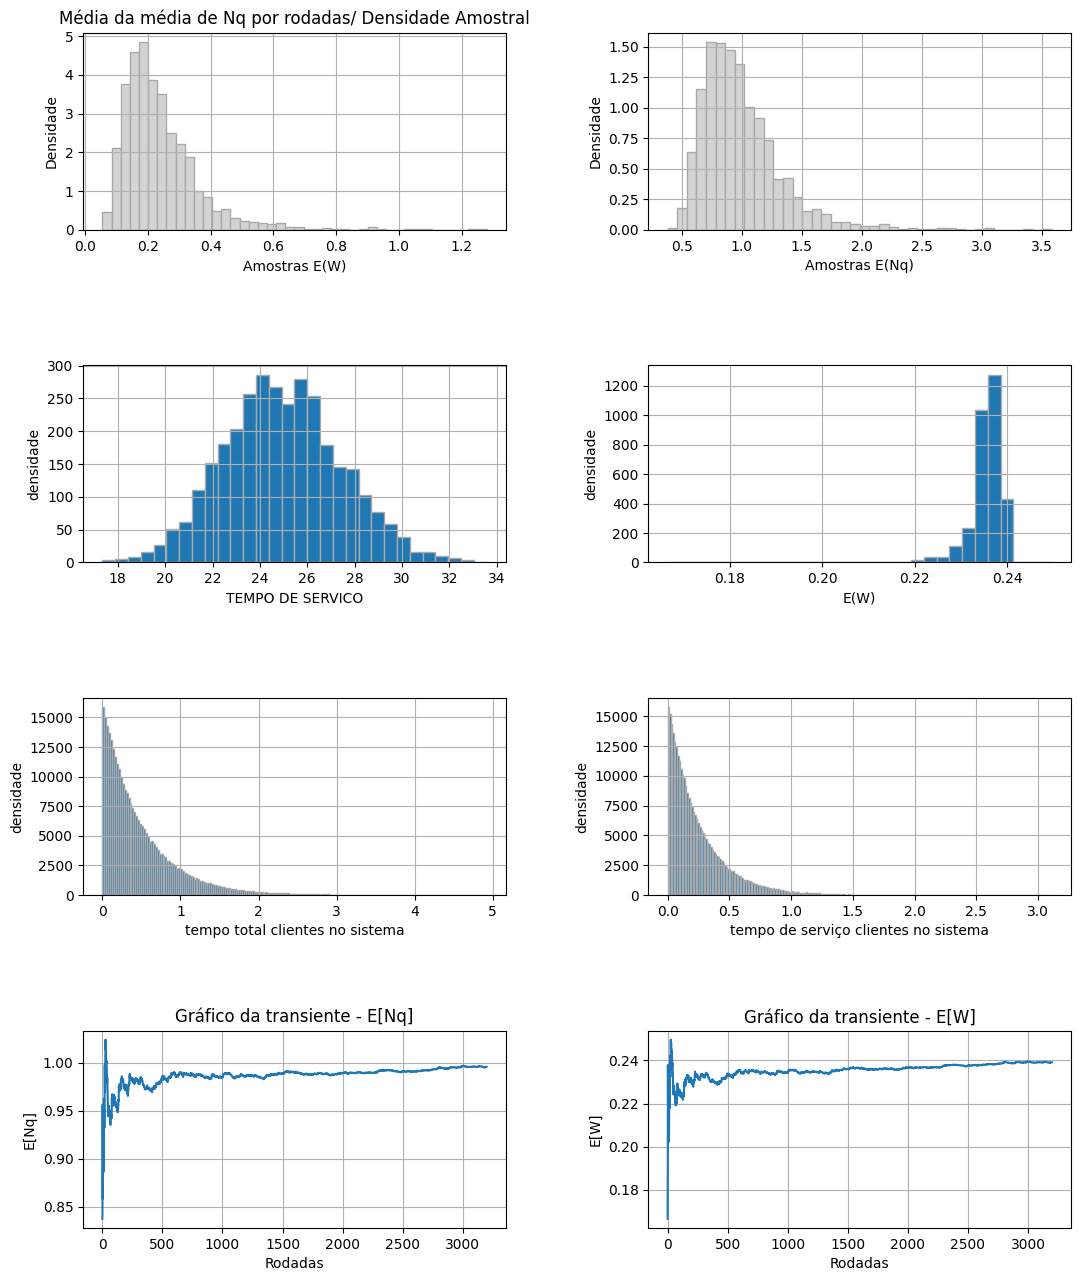

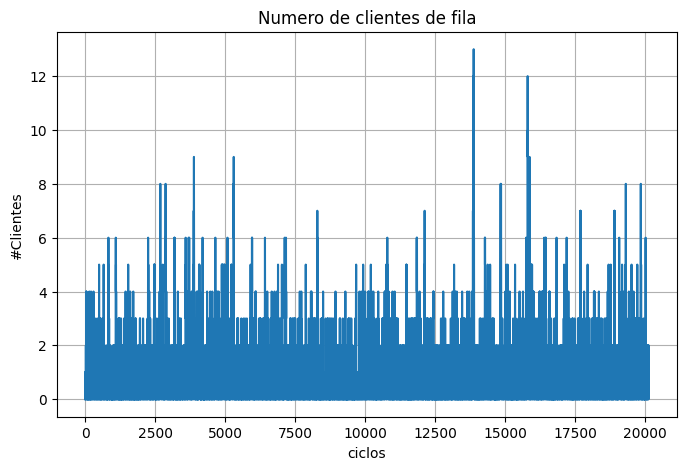

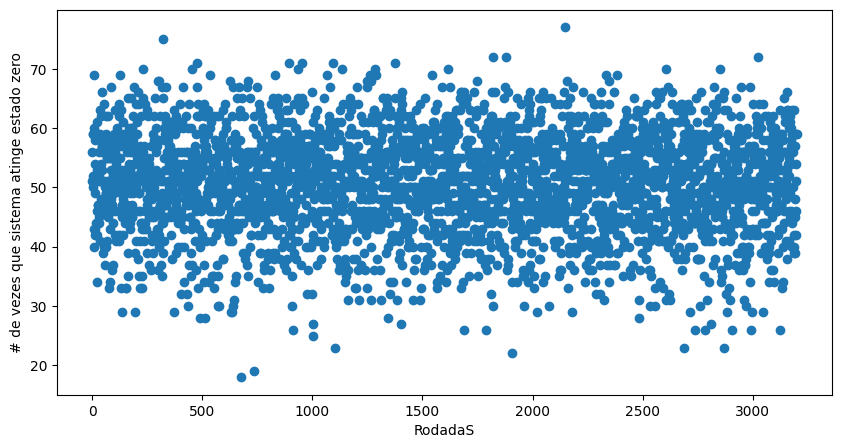

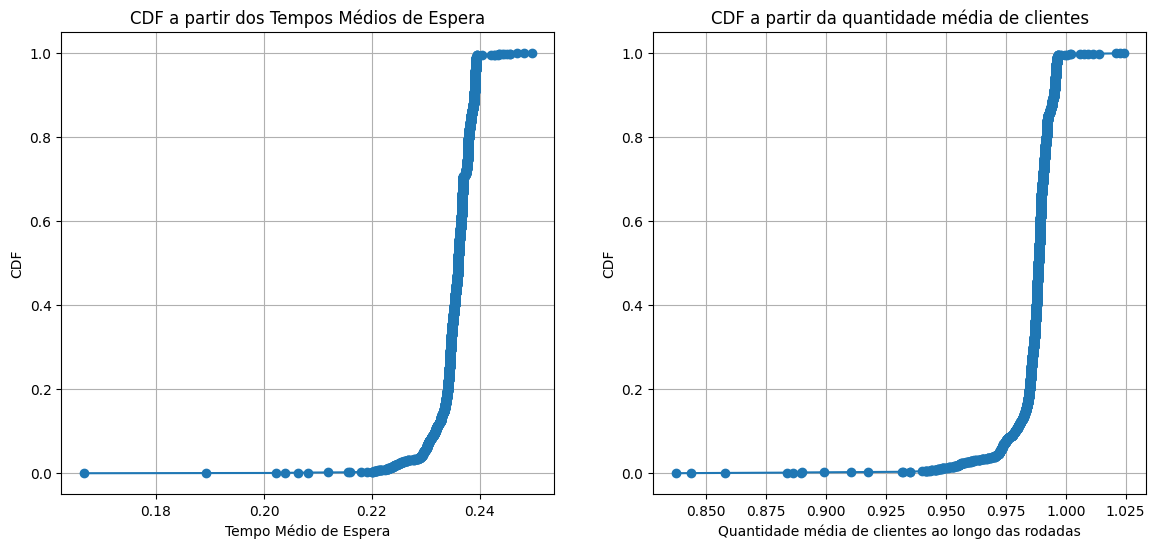

Média de W
IC: 0.235 a 0.243
Variância de W
IC: 0.156 a 0.167

Média de Nq
IC: 0.984 a 1.008
Variância de Nq
IC: 1.108 a 1.191

Média de vezes que sistema atinge estado zero por rodada
IC: 50.201 a 50.780

Média de tempo total dos clientes no sistema
IC: 0.472 a 0.505

Média de tempo de serviço dos clientes no sistema
IC: 0.241 a 0.258


[CORRETUDE] Calculando a Lei de little com base nos estimadores de
[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda
[CORRETUDE] Littles Law: 2.0380633287927608

Total de ciclos ocupados 160022
Fração de ciclos ocupados 5000.6875
Total de periodos ociosos: 159978
Fração de periodos ociosos: 4999.3125
[CORRETUDE] media do tempo de servico: 24.859343881080225 - 25.030951170788082
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 50.37654173098245 - 50.72664897167404
[CORRETUDE] Rho: 0.49345915499932325



In [ ]:
random.seed(0)
def exp40():
  return generate_exp(4.0)

def exp20():
  return generate_exp(2.0)
estimador_tempo_total.clear()
estimador_tempo_ocioso.clear()
estimador_tempo_servindo.clear()
estimador_cliente_tempo_total.clear()
estimador_cliente_tempo_servico.clear()

simulate(N_RODADAS, MIN_CLIENTES, exp20, exp40)

low_rho, up_rho = estimador_tempo_servindo.tstudent_ci()
print(f"[CORRETUDE] media do tempo de servico: {low_rho} - {up_rho}")

low_total, up_total = estimador_tempo_total.tstudent_ci()
print(f"[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): {low_total} - {up_total}")

print(f"[CORRETUDE] Rho: {estimador_tempo_servindo.mean()/estimador_tempo_total.mean()}\n")



## Caso 3 - Fila MM1

p = 1.05

lambda = 1.05

mi = 1

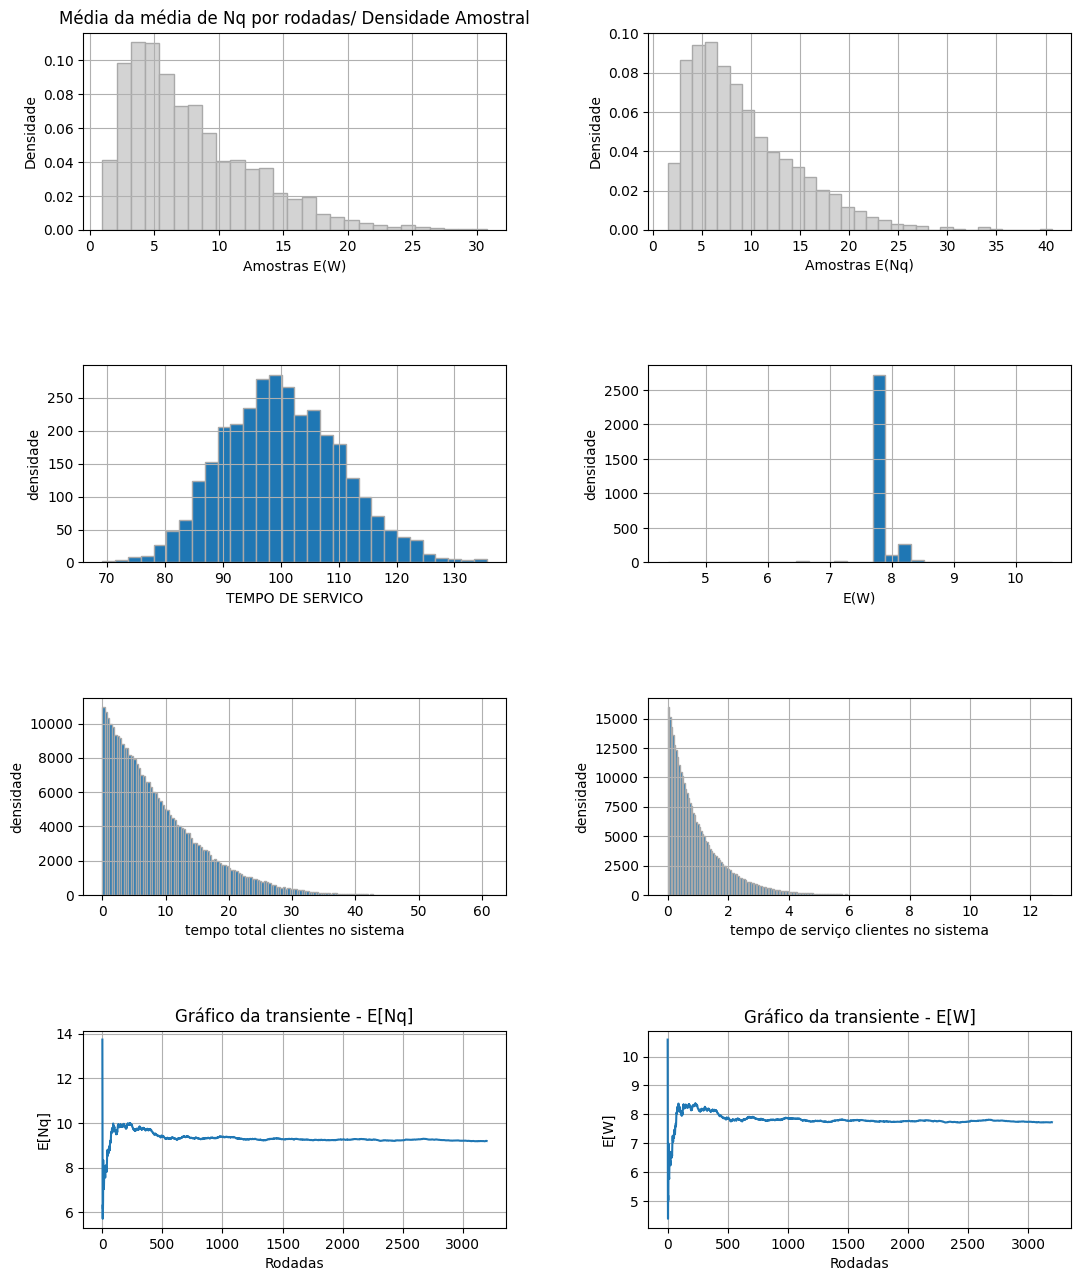

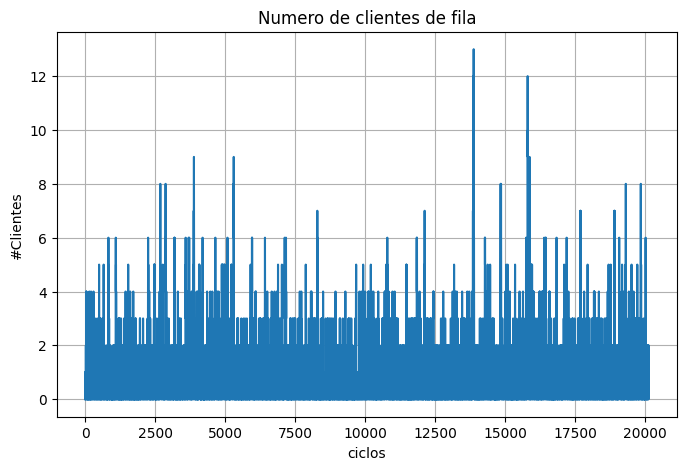

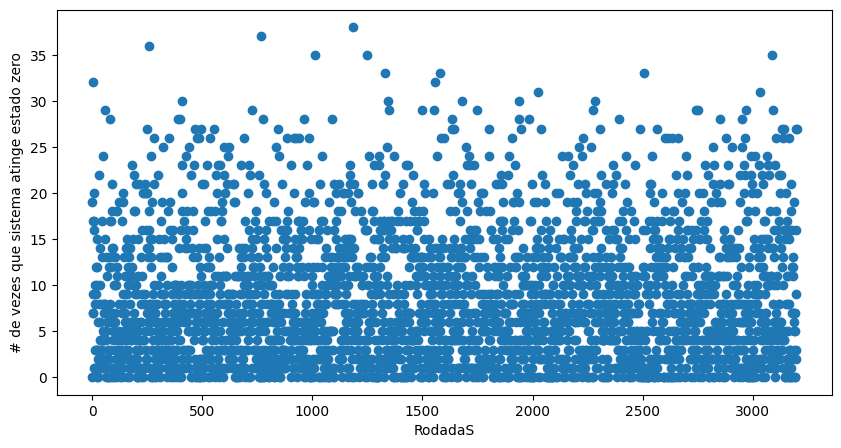

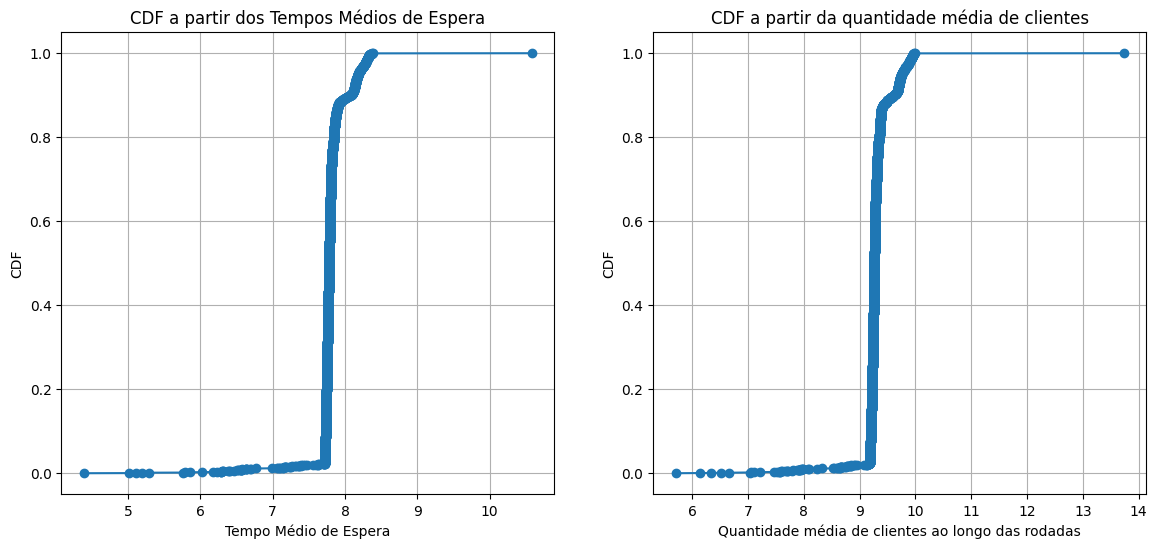

Média de W
IC: 7.563 a 7.896
Variância de W
IC: 29.578 a 31.938

Média de Nq
IC: 9.004 a 9.377
Variância de Nq
IC: 36.514 a 39.501

Média de vezes que sistema atinge estado zero por rodada
IC: 8.013 a 8.490

Média de tempo total dos clientes no sistema
IC: 8.476 a 8.988

Média de tempo de serviço dos clientes no sistema
IC: 0.968 a 1.037


[CORRETUDE] Calculando a Lei de little com base nos estimadores de
[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda
[CORRETUDE] Littles Law: 1.0524998138203132

Total de ciclos ocupados 293699
Fração de ciclos ocupados 9178.09375
Total de periodos ociosos: 26301
Fração de periodos ociosos: 821.90625
[CORRETUDE] media do tempo de servico: 99.91263701311246 - 100.61696878914216
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 108.73359007597313 - 109.3683993378838
[CORRETUDE] Rho: 0.9194304295030614



In [ ]:
#random.seed(0)
def exp10():
  return generate_exp(1.0)

def exp105():
  return generate_exp(1.05)

estimador_tempo_total.clear()
estimador_tempo_ocioso.clear()
estimador_tempo_servindo.clear()
estimador_cliente_tempo_total.clear()
estimador_cliente_tempo_servico.clear()

simulate(N_RODADAS, MIN_CLIENTES, exp105, exp10)

low_rho, up_rho = estimador_tempo_servindo.tstudent_ci()
print(f"[CORRETUDE] media do tempo de servico: {low_rho} - {up_rho}")

low_total, up_total = estimador_tempo_total.tstudent_ci()
print(f"[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): {low_total} - {up_total}")

print(f"[CORRETUDE] Rho: {estimador_tempo_servindo.mean()/estimador_tempo_total.mean()}\n")

## Caso 4 - Fila MM1

p = 1.10

lambda = 1.10

mi = 1

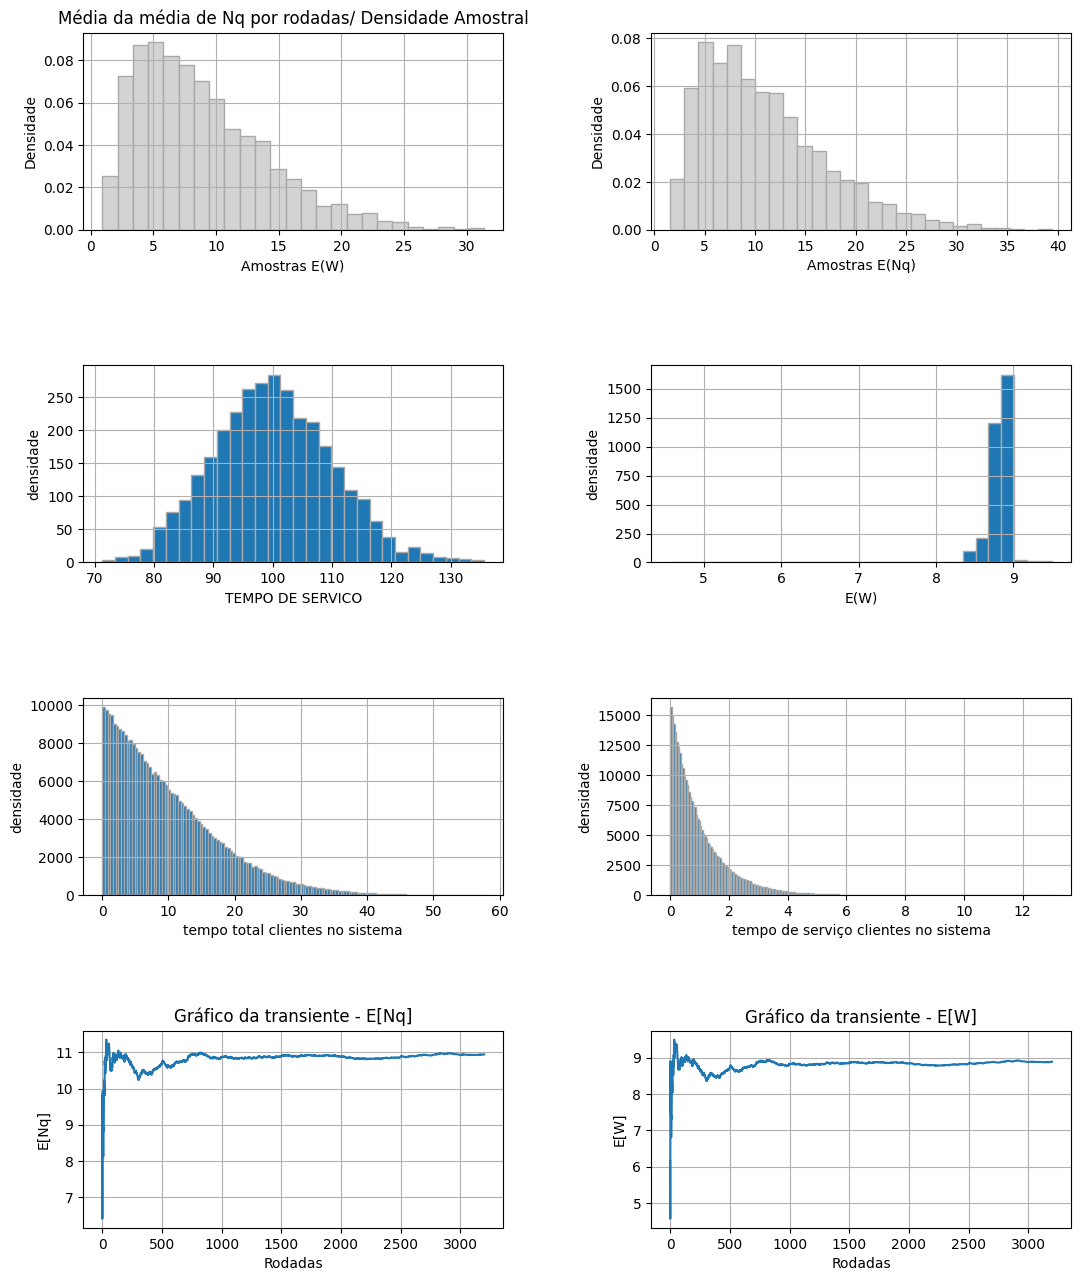

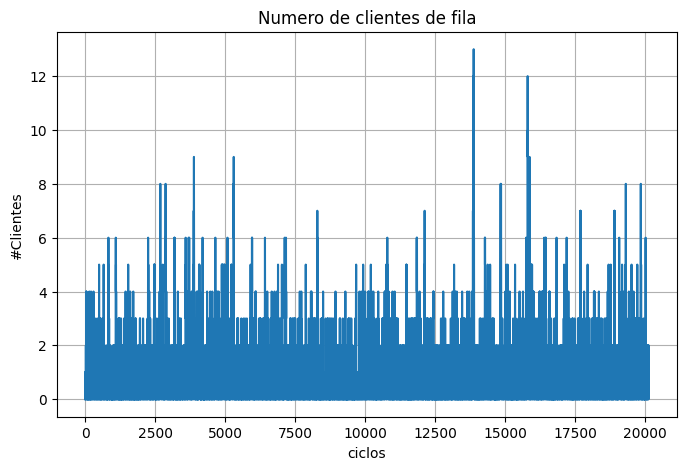

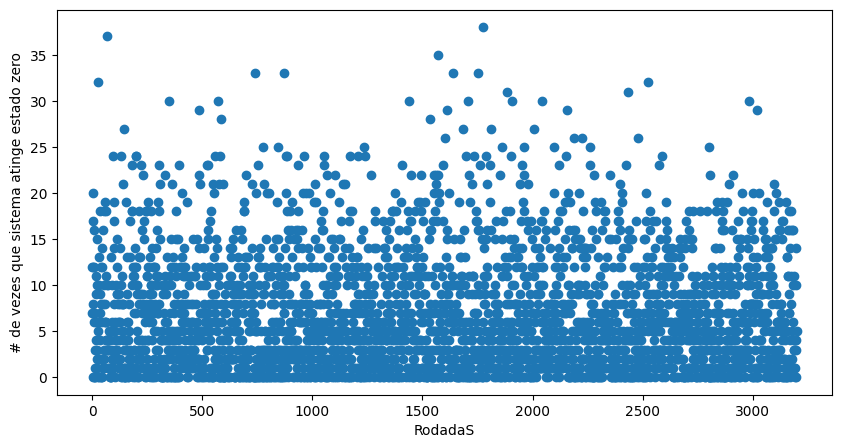

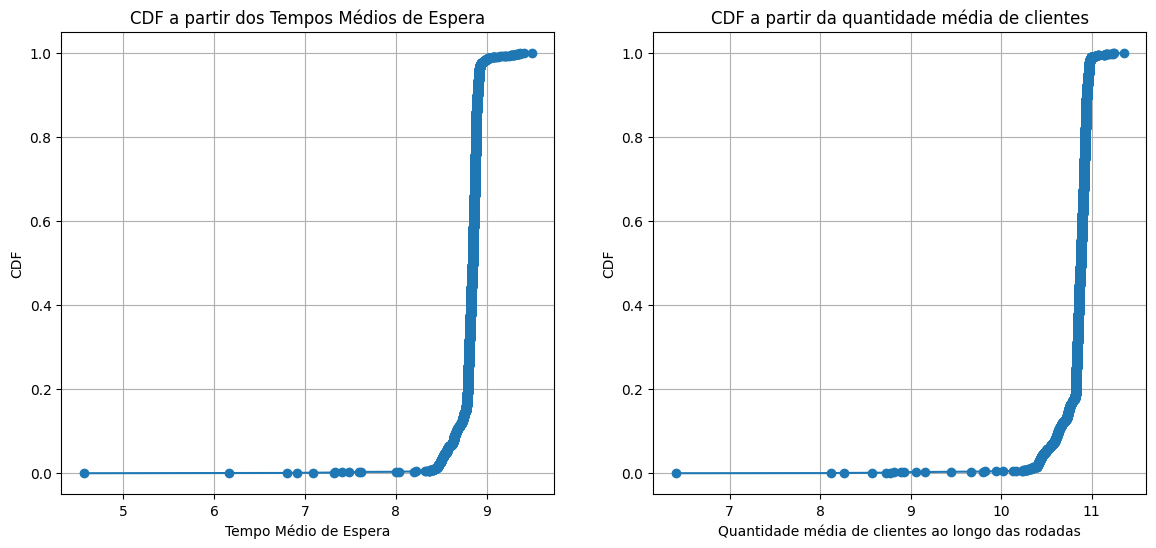

Média de W
IC: 8.710 a 9.068
Variância de W
IC: 36.255 a 38.939

Média de Nq
IC: 10.734 a 11.159
Variância de Nq
IC: 48.741 a 52.577

Média de vezes que sistema atinge estado zero por rodada
IC: 6.453 a 6.882

Média de tempo total dos clientes no sistema
IC: 9.611 a 10.169

Média de tempo de serviço dos clientes no sistema
IC: 0.967 a 1.036


[CORRETUDE] Calculando a Lei de little com base nos estimadores de
[CORRETUDE] media de tempo na fila/ media de tempo total  =  lambda
[CORRETUDE] Littles Law: 1.1068215437990645

Total de ciclos ocupados 298734
Fração de ciclos ocupados 9335.4375
Total de periodos ociosos: 21266
Fração de periodos ociosos: 664.5625
[CORRETUDE] media do tempo de servico: 99.76866154924554 - 100.46442428350286
[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): 106.75056100481753 - 107.38804291257593
[CORRETUDE] Rho: 0.935063002045118



In [ ]:
#random.seed(0)
def exp10():
  return generate_exp(1.0)

def exp110():
  return generate_exp(1.10)

estimador_tempo_total.clear()
estimador_tempo_ocioso.clear()
estimador_tempo_servindo.clear()
estimador_cliente_tempo_total.clear()
estimador_cliente_tempo_servico.clear()

simulate(N_RODADAS, MIN_CLIENTES, exp110, exp10)

low_rho, up_rho = estimador_tempo_servindo.tstudent_ci()
print(f"[CORRETUDE] media do tempo de servico: {low_rho} - {up_rho}")

low_total, up_total = estimador_tempo_total.tstudent_ci()
print(f"[CORRETUDE] media do tempo total no sistema (tempo ocioso + tempo de servico): {low_total} - {up_total}")

print(f"[CORRETUDE] Rho: {estimador_tempo_servindo.mean()/estimador_tempo_total.mean()}\n")

#GAMBLERS RUIN


In [ ]:
def simulate2(
    rounds,
    qeue_max_size,
    arrival_dist,
    service_dist,
    time_max_round
):

    # start up sistema
    t = 0.0
    nqueue = 0  #
    client_in_server = None

    # sistema começa com 1 chegada
    client_id = 0  # ID inicial dos clientes
    first_arrival = generate_arrival(t, arrival_dist, client_id)
    client_id += 1

    # Cria a lista de eventos, com o evento inicial
    events_list = EventsList()
    events_list.add(first_arrival)

    clients_queue = ClientsQueue()  # Cria a fila de espera de clientes, vazia

    # Quantidade de vezes que jogador faliu
    empty_queue_ocurrences = 0
    expected_time_to_ruin = 0
    expected_steps_to_ruin = 0

    # Quantidade de vezes que jogador chegou no sucesso
    full_queue_ocurrences = 0
    expected_time_to_win = 0
    expected_steps_to_win = 0

    for i in range(rounds):
        # Numero de clientes servidos na rodada
        served_clients = 0

        nqueue = 0 # zerando tamanho da fila
        n_atendimentos = 0

        n_clients_current = [] # clientes na fila por rodada

        # Conta o # de passos e o tempo ate terminar o jogo na rodada (ruin or win)
        round_time = 0
        steps = 0

        while round_time < time_max_round:

            # Seleciona o próximo evento e tira da lista
            event = events_list.pop()

            # Soma o passsos e time do GAMBLERS RUIN
            round_time += (event.t - t)
            steps += 1

            # Avança o tempo para o instante do evento
            t = event.t

            if event.event_type == ARRIVAL:
                new_client = create_client(event) # Cria um cliente

                if not client_in_server:
                    client_in_server = new_client # Coloca o cliente no servidor
                    serve_client(new_client, t, service_dist, events_list)  # Registra tempo de espera e adiciona evento do fim do serviço na lista

                else: # Se o servidor esta OCUPADO
                    clients_queue.add(new_client) # Adiciona o cliente na fila de espera
                    nqueue += 1 # Incrementa numero de clientes na fila de espera

                    if nqueue == qeue_max_size:
                        full_queue_ocurrences += 1
                        expected_time_to_win += round_time
                        expected_steps_to_win += steps
                        break

                new_arrival = generate_arrival(t, arrival_dist, client_id) # Cria nova chegada
                client_id += 1 # Incrementa id de cliente
                events_list.add(new_arrival)  # Adiciona nova chegada na lista de eventos
            else:
                served_clients += 1

                # NINGUEM na fila de espera
                if nqueue == 0:
                    client_in_server = None

                    empty_queue_ocurrences += 1
                    expected_time_to_ruin += round_time
                    expected_steps_to_ruin += steps
                    break

                else: # Se ha ALGUEM na fila de espera
                    client = clients_queue.pop()
                    client_in_server = client # Coloca o cliente no servidor
                    serve_client(client, t, service_dist, events_list)  # Registra tempo de espera e adiciona evento do fim do serviço na lista
                    nqueue -= 1 # Decrementa numero de clientes na fila de espera

            n_clients_current.append(nqueue)

        # zerando tempo de simulação e lista de eventos/clientes para próxima rodada
        client_in_server = None
        client_id = 0
        t = 0
        clients_queue.clear()
        events_list.clear()
        events_list.add(generate_arrival(t, arrival_dist, client_id))
        client_id += 1

    return {
        "empty_queue_ocurrences": empty_queue_ocurrences,
        "expected_time_to_ruin": expected_time_to_ruin,
        "expected_steps_to_ruin": expected_steps_to_ruin,
        "full_queue_ocurrences": full_queue_ocurrences,
        "expected_time_to_win": expected_time_to_win,
        "expected_steps_to_win": expected_steps_to_win
    }

###Caso 3

In [ ]:
def exp10():
  return generate_exp(1.0)

def exp105():
  return generate_exp(1.05)

LAMBDA = exp105

MU = exp10

QUEUE_MAX_SIZE = 4

N_RODADAS_GAMBLERS_RUIN = 40

TIME_MAX_ROUND = 100000

valores = simulate2(N_RODADAS_GAMBLERS_RUIN, QUEUE_MAX_SIZE, LAMBDA, MU, TIME_MAX_ROUND)


prob_time_ruin = valores["expected_time_to_ruin"]/valores["empty_queue_ocurrences"]
prob_steps_ruin = valores["expected_steps_to_ruin"]/valores["empty_queue_ocurrences"]
prob_ruin = valores["empty_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

prob_time_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_steps_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_win = valores["full_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

print(f"""Fração de ruinas: {prob_ruin}""")
print(f"""Fração tempo até a ruina: {prob_time_ruin:.5f}""")
print(f"""Fração de passos até a ruina: {prob_steps_ruin:.5f}""")

print(f"""\nFração de fortuna: {prob_win}""")
print(f"""Fração tempo até a fortuna: {prob_time_win:.5f}""")
print(f"""Fração de passos até a fortuna: {prob_steps_win:.5f}""")

Fração de ruinas: 0.825
Fração tempo até a ruina: 2.75554
Fração de passos até a ruina: 4.24242

Fração de fortuna: 0.175
Fração tempo até a fortuna: 6.12062
Fração de passos até a fortuna: 6.12062


###Caso 4

In [ ]:
def exp10():
  return generate_exp(1.0)

def exp110():
  return generate_exp(1.10)

LAMBDA = exp110

MU = exp10

QUEUE_MAX_SIZE = 4

N_RODADAS_GAMBLERS_RUIN = 40

TIME_MAX_ROUND = 100000

valores = simulate2(N_RODADAS_GAMBLERS_RUIN, QUEUE_MAX_SIZE, LAMBDA, MU, TIME_MAX_ROUND)

prob_time = valores["expected_time_to_ruin"]/valores["empty_queue_ocurrences"]
prob_steps = valores["expected_steps_to_ruin"]/valores["empty_queue_ocurrences"]
prob_ruin = valores["empty_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

prob_time_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_steps_win = valores["expected_time_to_win"]/valores["full_queue_ocurrences"]
prob_win = valores["full_queue_ocurrences"]/N_RODADAS_GAMBLERS_RUIN

print(f"""Fração de ruinas: {prob_ruin}""")
print(f"""Fração tempo até a ruina: {prob_time_ruin:.5f}""")
print(f"""Fração de passos até a ruina: {prob_steps_ruin:.5f}""")

print(f"""\nFração de fortuna: {prob_win}""")
print(f"""Fração tempo até a fortuna: {prob_time_win:.5f}""")
print(f"""Fração de passos até a fortuna: {prob_steps_win:.5f}""")

Fração de ruinas: 0.8
Fração tempo até a ruina: 2.75554
Fração de passos até a ruina: 4.24242

Fração de fortuna: 0.2
Fração tempo até a fortuna: 4.61190
Fração de passos até a fortuna: 4.61190
